У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import darts
from darts import TimeSeries
from darts.utils.statistics import check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift
from darts.metrics import mape
from darts.models import XGBModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import ExponentialSmoothing


In [6]:
df = pd.read_csv('train.csv.zip', parse_dates=['date'], index_col='date')

In [7]:
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [9]:
monthly_sales = df.groupby([pd.Grouper(freq='M'), 'item'])['sales'].mean().reset_index()

selected_items = [1, 10, 20, 30, 40, 50]
filtered_monthly_sales = monthly_sales[monthly_sales['item'].isin(selected_items)]

fig = px.line(
    filtered_monthly_sales,
    x='date',
    y='sales',
    color='item',
    title='Динаміка щомісячних продажів для обраних товарів',
    labels={'date': 'Дата', 'sales': 'Середні продажі', 'item': 'Товар'}
)

fig.update_layout(
    xaxis_title_text='Дата',
    yaxis_title_text='Середні продажі',
    legend_title_text='Товар',
    hovermode='x unified'
)

fig.show()

/tmp/ipython-input-672571142.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby([pd.Grouper(freq='M'), 'item'])['sales'].mean().reset_index()


/tmp/ipython-input-1363616507.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



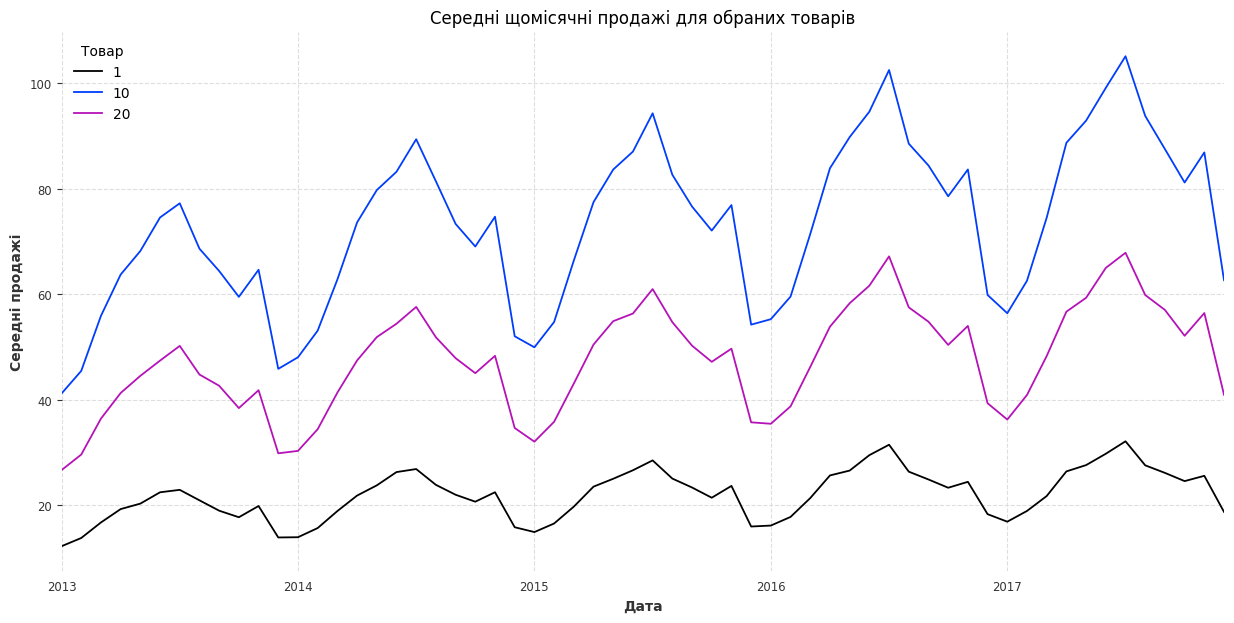

In [10]:
monthly_item_sales = df.groupby([pd.Grouper(freq='M'), 'item'])['sales'].mean().unstack()

plt.figure(figsize=(15, 7))
monthly_item_sales[[1, 10, 20]].plot(ax=plt.gca())
plt.title('Середні щомісячні продажі для обраних товарів')
plt.xlabel('Дата')
plt.ylabel('Середні продажі')
plt.legend(title='Товар')
plt.grid(True, linestyle='--')
plt.show()

In [11]:
total_sales_by_item = df.groupby('item')['sales'].sum()
top_5_items = total_sales_by_item.nlargest(5).index.tolist()

top_5_df = df[df['item'].isin(top_5_items)]
monthly_top_5_sales = top_5_df.groupby([pd.Grouper(freq='M'), 'item'])['sales'].sum().reset_index()

fig = px.line(
    monthly_top_5_sales,
    x='date',
    y='sales',
    color='item',
    title='Динаміка щомісячних продажів для 5 найбільш популярних товарів',
    labels={'date': 'Дата', 'sales': 'Продажі', 'item': 'Товар'}
)

fig.update_layout(
    xaxis_title_text='Дата',
    yaxis_title_text='Загальні продажі',
    legend_title_text='Товар',
    hovermode='x unified'
)

fig.show()

/tmp/ipython-input-1323921072.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



/tmp/ipython-input-2537721214.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




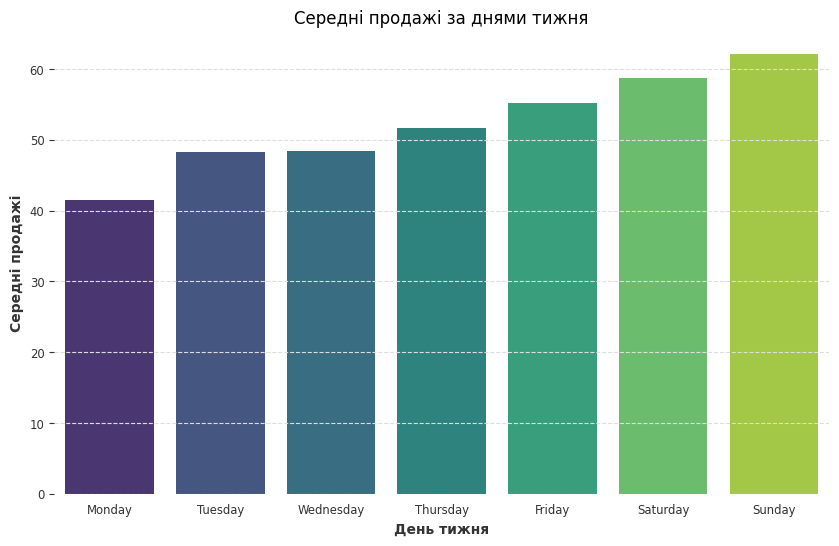

In [12]:
df['weekday'] = df.index.day_name()
df['month'] = df.index.month_name()

sales_by_weekday = df.groupby('weekday')['sales'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_weekday.index, y=sales_by_weekday.values, palette='viridis')
plt.title('Середні продажі за днями тижня')
plt.xlabel('День тижня')
plt.ylabel('Середні продажі')
plt.grid(axis='y', linestyle='--')
plt.show()

/tmp/ipython-input-661864288.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




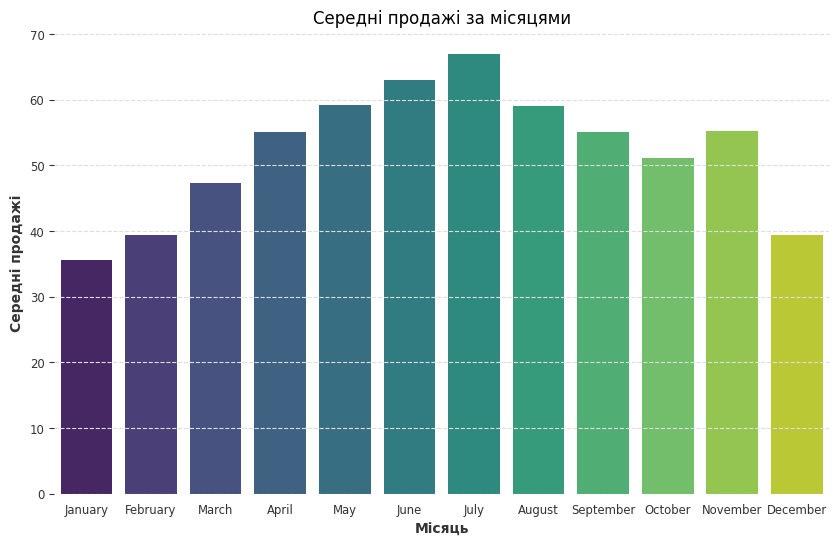

In [13]:
sales_by_month = df.groupby('month')['sales'].mean().reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_month.index, y=sales_by_month.values, palette='viridis')
plt.title('Середні продажі за місяцями')
plt.xlabel('Місяць')
plt.ylabel('Середні продажі')
plt.grid(axis='y', linestyle='--')
plt.show()

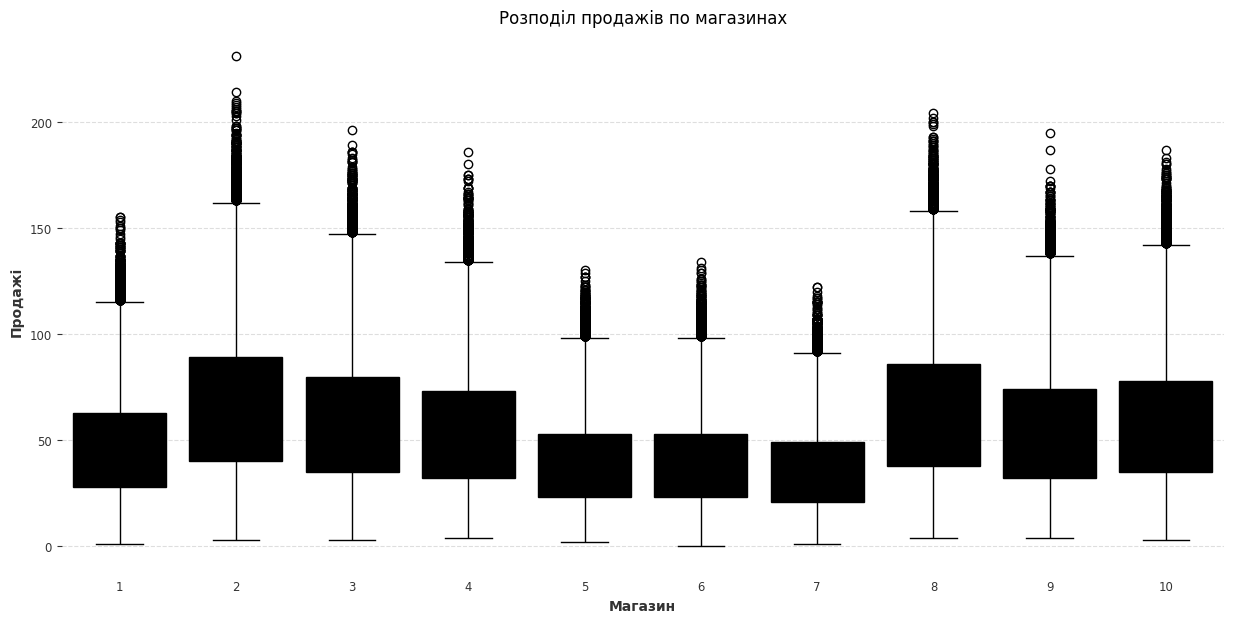

In [14]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='store', y='sales', data=df)
plt.title('Розподіл продажів по магазинах')
plt.xlabel('Магазин')
plt.ylabel('Продажі')
plt.grid(axis='y', linestyle='--')
plt.show()

**Висновки**

На вищепобудованих графіках ми можемо спостерігати наступне:

- **Сильна сезонність**: На графіках щомісячних продажів чітко видно виражену сезонність. Продажі стабільно зростають з весни до літа, досягаючи піку в липні, а потім знижуються до кінця року, з мінімумом у грудні та січні. Ця закономірність спостерігається з року в рік, що вказує на сильний вплив сезонних факторів.

- **Вплив днів тижня**: Бар-чарт середніх продажів за днями тижня демонструє, що продажі значно відрізняються залежно від дня. Найвищі продажі припадають на вихідні дні (суботу та неділю), тоді як у понеділок і вівторок вони найнижчі. Це логічно, оскільки люди частіше роблять покупки у вільний від роботи час.

- **Взаємозалежність товарів**: Графік щомісячних продажів для різних товарів демонструє, що всі товари мають схожий сезонний патерн. Коли продажі одного товару зростають, продажі інших також демонструють зростання, і навпаки. Це означає, що зовнішні фактори, такі як свята чи сезон, впливають на продажі всіх товарів одночасно. Це важливий інсайт, який можна використати при побудові моделі.

- **Стабільність лідерів**: Незважаючи на коливання, співвідношення продажів між цими товарами залишається досить стабільним. Наприклад, товар №28 постійно демонструє найвищі показники продажів, а товар №13 — найнижчі з п'яти представлених. Це говорить про те, що позиції лідерів ринку в цій групі товарів не змінюються протягом досліджуваного періоду.

- **Різниця між магазинами**: Діаграма box plot показує, що середній рівень продажів і їх волатильність значно відрізняються між магазинами. Наприклад, магазин №2 та №8 мають значно вищі середжні продажі та більший розкид, ніж, наприклад, магазин №7. Це свідчить про те, що магазини мають різний потенціал і динаміку, і для точного прогнозування їх потрібно аналізувати окремо.



3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

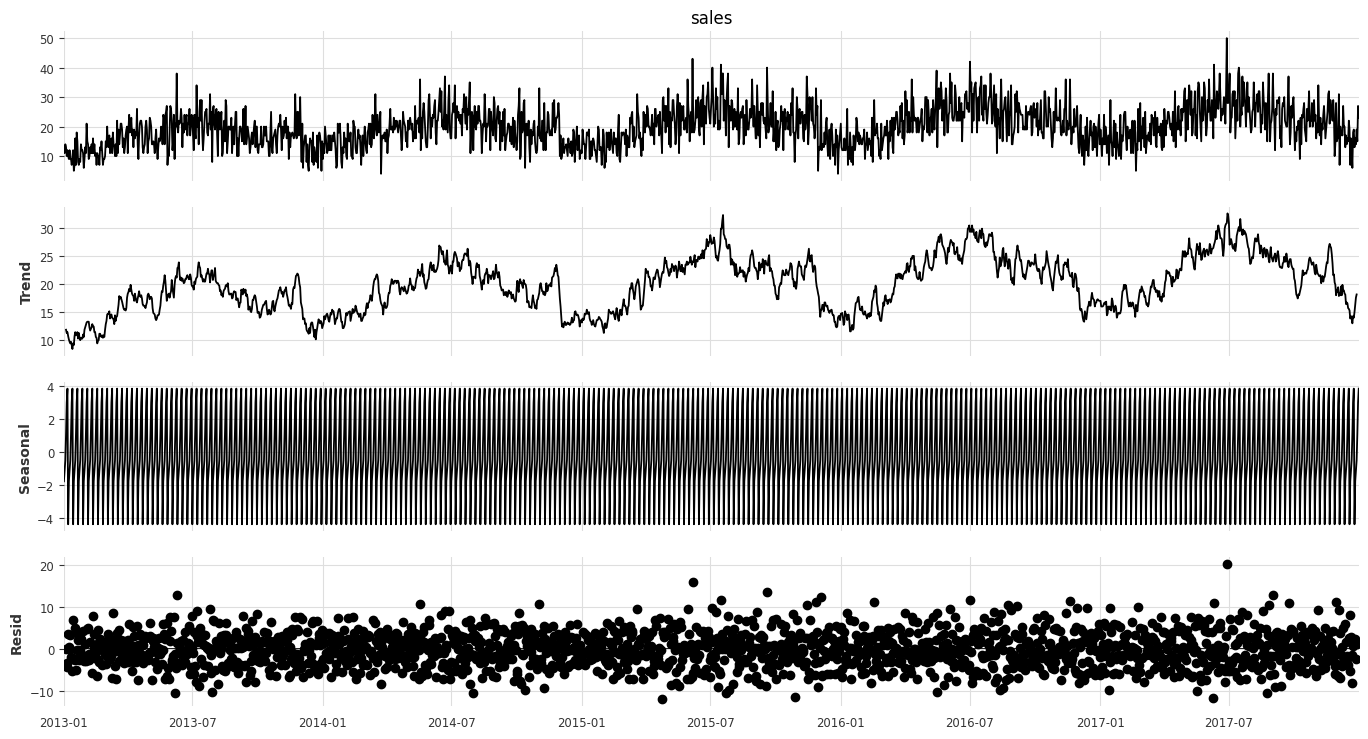

In [15]:
ts = df[(df['store'] == 1) & (df['item'] == 1)]['sales']

# Тижнева сезонність
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

/tmp/ipython-input-113727112.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



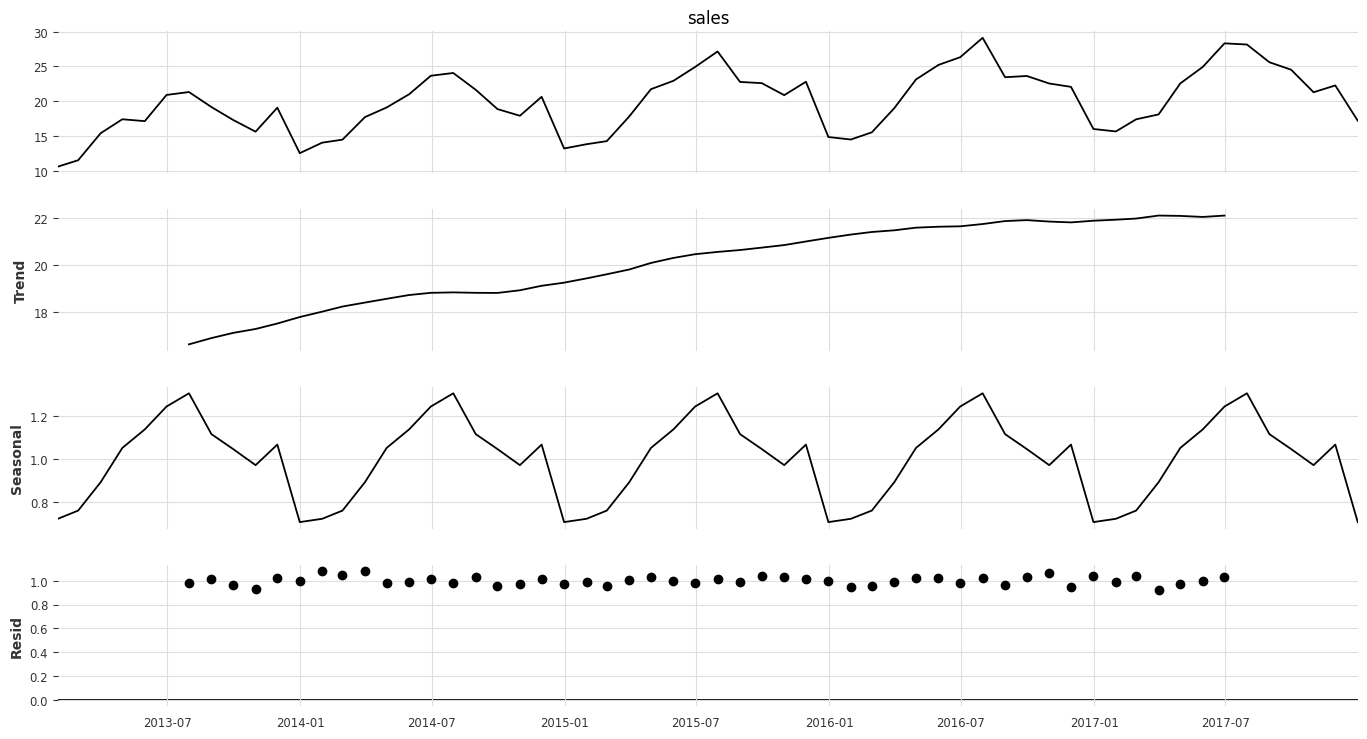

In [16]:
monthly_ts = ts.resample('M').mean()

# Місячна сезонність
decomposition = sm.tsa.seasonal_decompose(monthly_ts, model='multiplicative', period=12)

fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

**Висновки**

Графік 1: Тижнева сезонність (щоденні дані).

- Тренд: На графіку тренду видно, що продажі мають загальну тенденцію до зростання протягом усього 5-річного періоду. Однак, тренд не є монотонно зростаючим — він має певні коливання, які вказують на більш складні довгострокові закономірності (можливо, річну сезонність).

- Сезонність: Графік сезонності чітко показує сильний тижневий цикл. Ми бачимо повторювані патерни з високими продажами у вихідні та низькими в будні. Це підтверджує, що день тижня є критично важливим фактором для прогнозування.

- Залишки: Залишки здаються хаотичними і розподілені навколо нуля, що свідчить про те, що модель добре впоралася з виділенням тренду та тижневої сезонності. Однак, деякі "викиди" можуть свідчити про вплив зовнішніх подій, таких як свята.

Графік 2: Місячна сезонність (щомісячні дані).

- Тренд: На цьому графіку є набагато більш згладженим і чітко показує монотонне зростання продажів протягом 5 років. Це є більш точним відображенням довгострокової тенденції, оскільки щомісячна агрегація усуває щоденний шум.

- Сезонність: Графік сезонності підтверджує сильний річний цикл. Видно, що продажі зростають з січня до липня, а потім падають до грудня. Цей патерн є дуже послідовним протягом кожного року.

- Залишки: Залишки здаються добре розподіленими і не мають очевидних патернів, що свідчить про те, що мультиплікативна модель добре підійшла для декомпозиції.



4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [17]:
series = TimeSeries.from_series(ts)

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

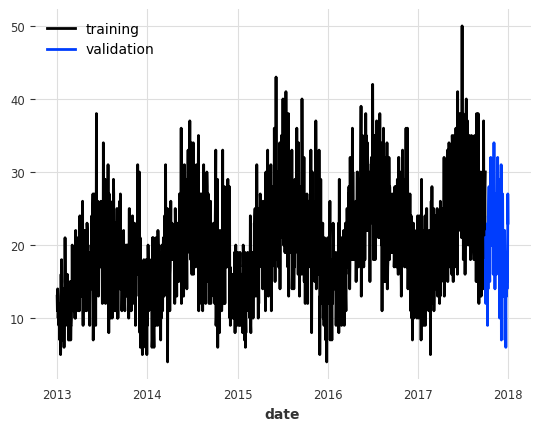

In [18]:
train, val = series.split_before(pd.Timestamp('2017-10-01'))

train.plot(label="training")
val.plot(label="validation")

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [19]:
ts_pandas = pd.Series(series.values().flatten(), index=series.time_index)

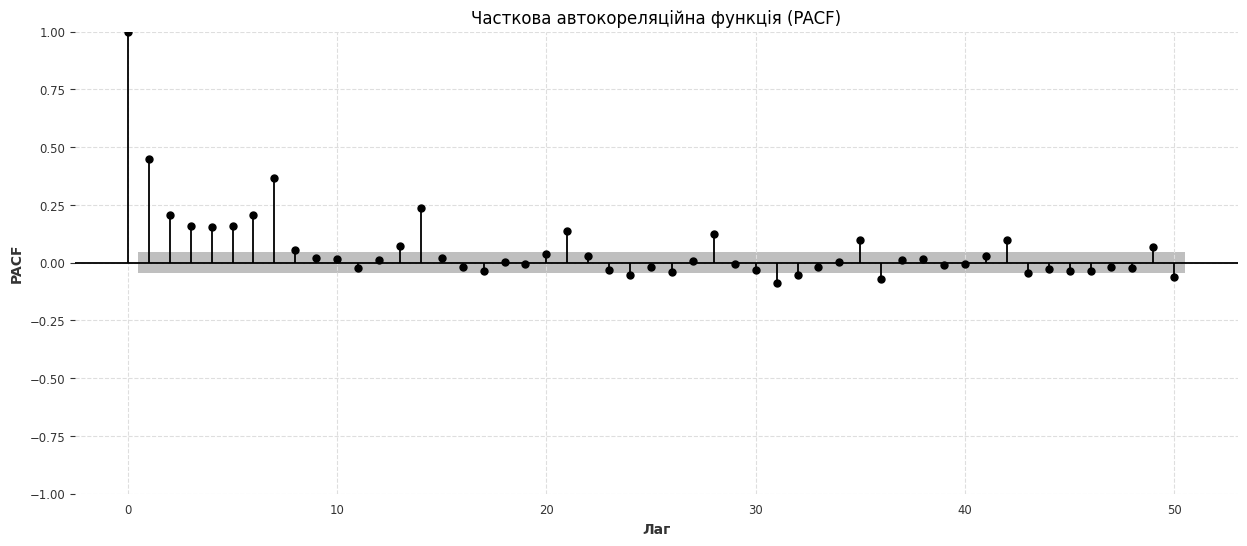

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sm.graphics.tsa.plot_pacf(ts_pandas, lags=50, ax=ax)
plt.title('Часткова автокореляційна функція (PACF)')
plt.xlabel('Лаг')
plt.ylabel('PACF')
plt.grid(True, linestyle='--')
plt.show()

**Спостереження**

На отриманому графіку PACF можна виділити наступні ключові моменти:

- **Лаг 1** є найбільшим і виходить далеко за межі довірчого інтервалу. Це свідчить про сильну позитивну кореляцію. Це означає, що продажі сьогодні мають дуже сильний прямий зв'язок з продажами попереднього дня. Це цілком очікувано для часових рядів.

- **Лаг 7** є другим за значущістю і також виходить за межі довірчого інтервалу. Це підтверджує, що продажі сьогодні мають прямий і важливий зв'язок з продажами тиждень тому (у той самий день тижня). Це є яскравим свідченням сильної тижневої сезонності, яку ми вже бачили на попередніх графіках.

- **Лаг 14, 21, ...** на графіку видно менші, але все ще помітні сплески на лагах, кратних 7 (наприклад, 14, 21, 28, 35, 42). Це свідчить, що вплив тижневої закономірності продовжується на кілька тижнів вперед.

- Є також декілька інших лагів, які трохи виходять за межі довірчого інтервалу, наприклад, біля лагу 20 і 30. Вони можуть вказувати на інші, менш виражені, але все ще значущі патерни.

**Висновки**

- **Найважливіші ознаки**: Для прогнозування продажів сьогоднішнього дня, найважливішими предикторами будуть продажі попереднього дня (лаг 1) та продажі тиждень тому (лаг 7).

- **Тижнева сезонність**: Графік однозначно підтверджує наявність сильної тижневої сезонності. Будь-яка модель прогнозування повинна враховувати цей фактор.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [21]:
is_weekly_seasonal = check_seasonality(train, m=7, max_lag=200, alpha=0.05)
print(f"Чи є тижнева сезонність? {is_weekly_seasonal}")

is_yearly_seasonal = check_seasonality(train, m=365, max_lag=2000, alpha=0.05)
print(f"Чи є річна сезонність? {is_yearly_seasonal}")

Чи є тижнева сезонність? (True, 7)
Чи є річна сезонність? (False, 365)


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [22]:
# Модель NaiveSeasonal (період = 7)
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)

seasonal_forecast = seasonal_model.predict(len(val))

# Модель NaiveDrift
drift_model = NaiveDrift()
drift_model.fit(train)

drift_forecast = drift_model.predict(len(val))

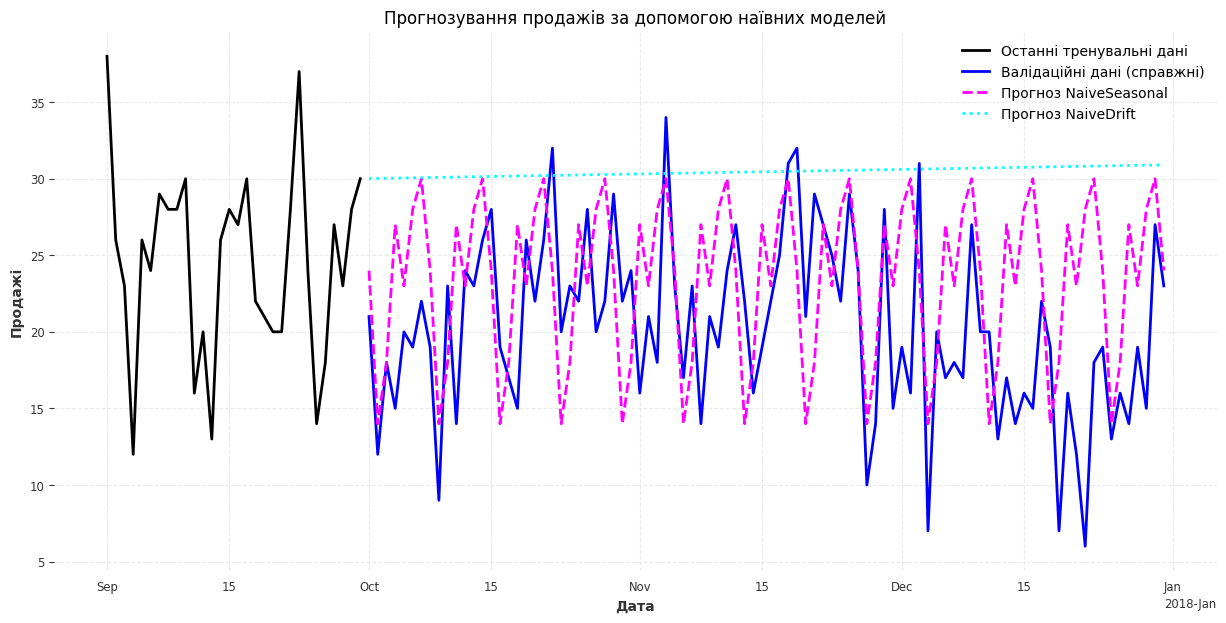

In [23]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
seasonal_forecast.plot(label="Прогноз NaiveSeasonal", color='magenta', linestyle='--', linewidth=2)
drift_forecast.plot(label="Прогноз NaiveDrift", color='cyan', linestyle=':', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Висновок**

Модель NaiveDrift: ця модель, представлена бірюзовою пунктирною лінією, є абсолютно неточною. Вона прогнозує пряму лінію з невеликим позитивним нахилом, повністю ігноруючи сильну тижневу сезонність, що присутня у валідаційних даних. Її прогноз є нерелевантним для цього набору даних.

Модель NaiveSeasonal: Ця модель, представлена пурпурною пунктирною лінією, і є досить точною для простої наївної моделі. Вона успішно захоплює тижневий сезонний патерн, який є ключовим у цьому часовому ряді. Ми можемо бачити, що її прогнозні піки та спади збігаються з піками та спадами справжніх даних (синя лінія). Це свідчить про те, що сезонність є найважливішим фактором для прогнозування.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [24]:
mape_error = mape(val, seasonal_forecast)

print(f"Помилка MAPE для моделі NaiveSeasonal: {mape_error:.2f}%")

Помилка MAPE для моделі NaiveSeasonal: 38.17%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [25]:
day_of_week = datetime_attribute_timeseries(train, attribute='dayofweek', one_hot=True)
val_day_of_week = datetime_attribute_timeseries(val, attribute='dayofweek', one_hot=True)

month_of_year = datetime_attribute_timeseries(train, attribute='month', one_hot=True)
val_month_of_year = datetime_attribute_timeseries(val, attribute='month', one_hot=True)

day_of_year = datetime_attribute_timeseries(train, attribute='dayofyear')
val_day_of_year = datetime_attribute_timeseries(val, attribute='dayofyear')

In [26]:
xgb_model = XGBModel(lags=14, lags_future_covariates=[0])

xgb_model.fit(train,future_covariates=day_of_week.stack(month_of_year).stack(day_of_year))

xgb_forecast = xgb_model.predict(
    n=len(val),
    future_covariates=val_day_of_week.stack(val_month_of_year).stack(val_day_of_year)
)

In [27]:
mape_error = mape(val, xgb_forecast)
print(f"Помилка MAPE для моделі XGBoost: {mape_error:.2f}%")

Помилка MAPE для моделі XGBoost: 24.50%


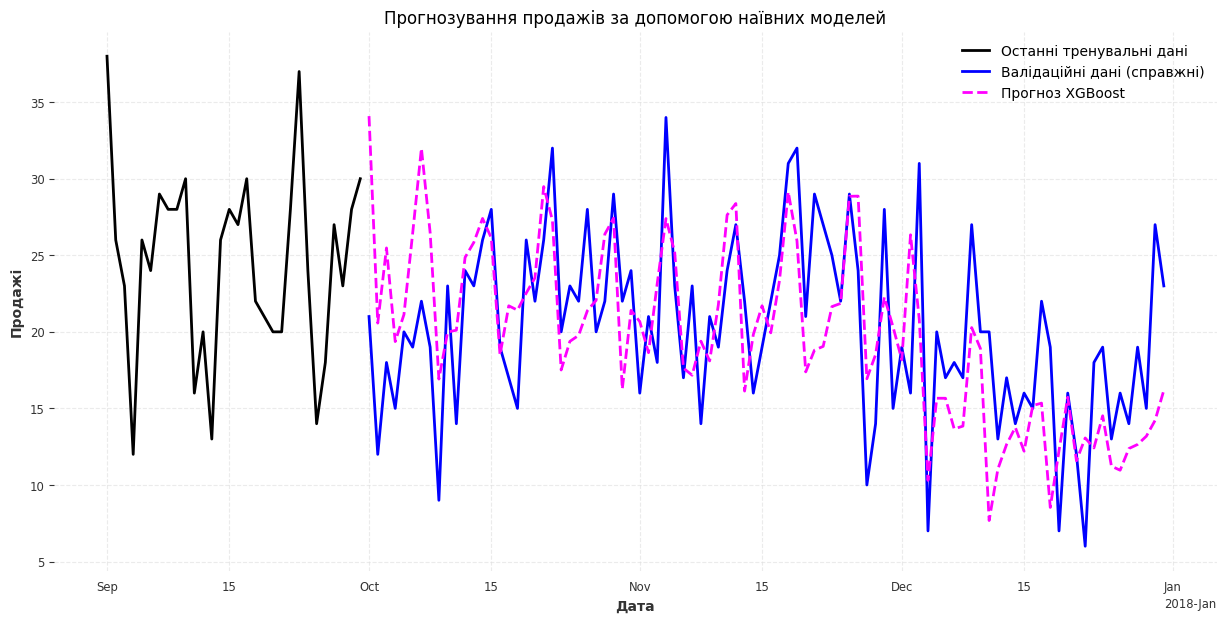

In [28]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
xgb_forecast.plot(label="Прогноз XGBoost", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Висновки**

- Спростерігається значне покращення порівняно з наївною моделлю: Помилка MAPE знизилася з 38.17% до 24.50%. Це є значним покращенням і доводить, що модель XGBoost, завдяки врахуванню додаткових ознак, є значно точнішою.

- На графіку видно, що прогноз XGBoost не тільки повторює тижневі коливання, але й більш точно слідує за загальним трендом валідаційного періоду. Модель навчилася, що продажі в жовтні-листопаді мають тенденцію до зниження, і врахувала це у своєму прогнозі. Наївні моделі цього зробити не могли.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [29]:
from darts.utils.utils import TrendMode, SeasonalityMode
from darts.utils.utils import ModelMode

In [30]:
exp_smoothing_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=ModelMode.ADDITIVE,
    seasonal_periods=7,
    damped=True
)
exp_smoothing_model.fit(train)
exp_smoothing_forecast = exp_smoothing_model.predict(len(val))

In [31]:
mape_error = mape(val, exp_smoothing_forecast)
print(f"Помилка MAPE для моделі ExponentialSmoothing: {mape_error:.2f}%")

Помилка MAPE для моделі ExponentialSmoothing: 36.65%


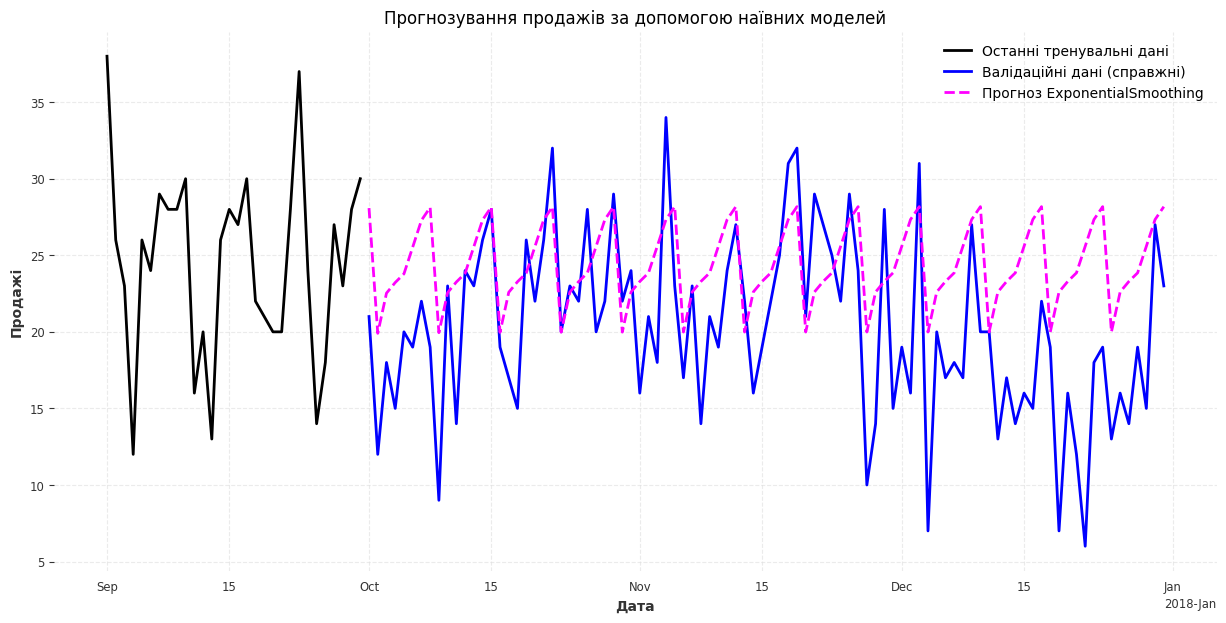

In [32]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
exp_smoothing_forecast.plot(label="Прогноз ExponentialSmoothing", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Висновок**

Помилка MAPE для моделі ExponentialSmoothing становить 36.65%, що все ще гірше, ніж у наївної моделі. Це свідчить про те що або я щось наплутала, або модель не змогла повністю перевершити простоту і силу наївного прогнозування на цих даних.

Якщо правильно зрозуміла ExponentialSmoothing модель добре працює з даними, що мають стабільний тренд і сезонність, але може бути менш ефективною, коли патерни змінюються або є непередбачувані сплески. Вона не може враховувати зовнішні фактори, як це робить XGBoost. І так як модель XGBoost змогла показати кращі результати (24.50% MAPE). Це підкреслює, що для цих даних зовнішні ознаки, такі як день тижня та місяць, є критично важливими для отримання точного прогнозу.

Або треба припинити виконання домашнього завдання вночі))

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [33]:
from darts.models import ARIMA

In [34]:
# Параметри p, d, q
p_param = 7
d_param = 1
q_param = 1

In [35]:
arima_model = ARIMA(p=p_param, d=d_param, q=q_param)
arima_model.fit(train)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



ARIMA(p=7, d=1, q=1, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [36]:
arima_forecast = arima_model.predict(len(val))

In [37]:
mape_error = mape(val, arima_forecast)
print(f"Помилка MAPE для моделі ARIMA: {mape_error:.2f}%")

Помилка MAPE для моделі ARIMA: 39.53%


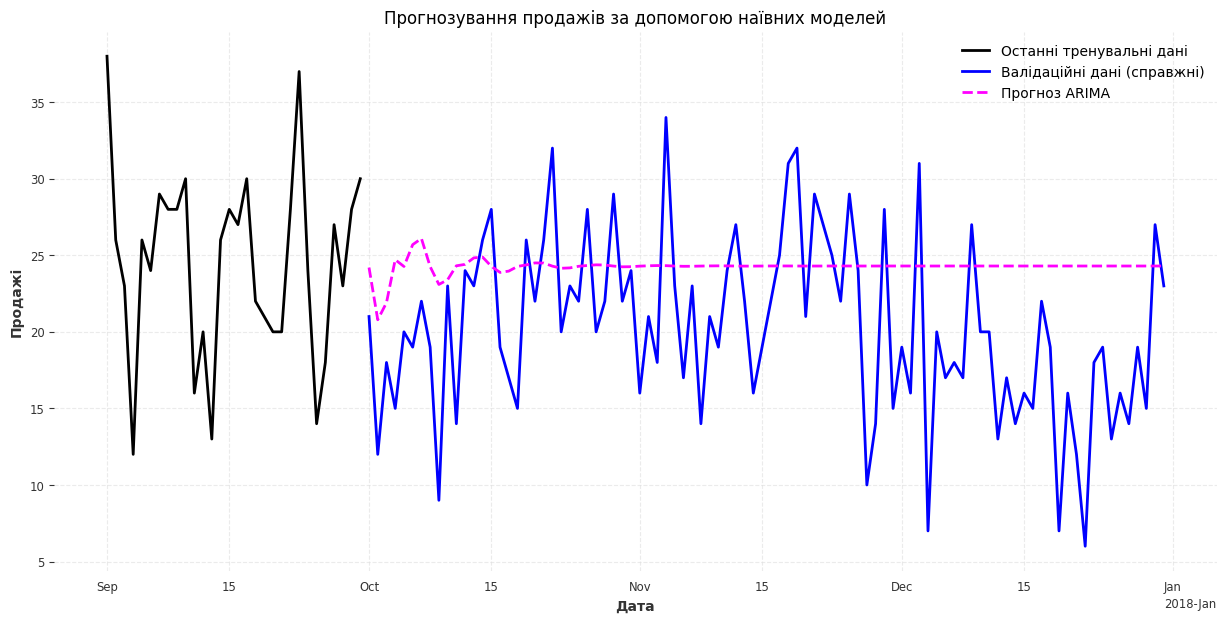

In [38]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
arima_forecast.plot(label="Прогноз ARIMA", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Висновки**

Отриманий результат показує, що модель ARIMA з обраними параметрами є неточною. Помилка MAPE для цієї моделі становить 39.53%, що є найгіршим показником серед усіх протестованих моделей.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [39]:
from darts.utils.statistics import plot_acf, plot_pacf
from darts.utils.utils import ModelMode

In [40]:
auto_arima_model = ARIMA()

auto_arima_model.fit(train)

ARIMA(p=12, d=1, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [41]:
auto_arima_forecast = auto_arima_model.predict(len(val))

In [42]:
mape_error = mape(val, auto_arima_forecast)
print(f"Помилка MAPE для оптимізованої ARIMA: {mape_error:.2f}%")

Помилка MAPE для оптимізованої ARIMA: 39.49%


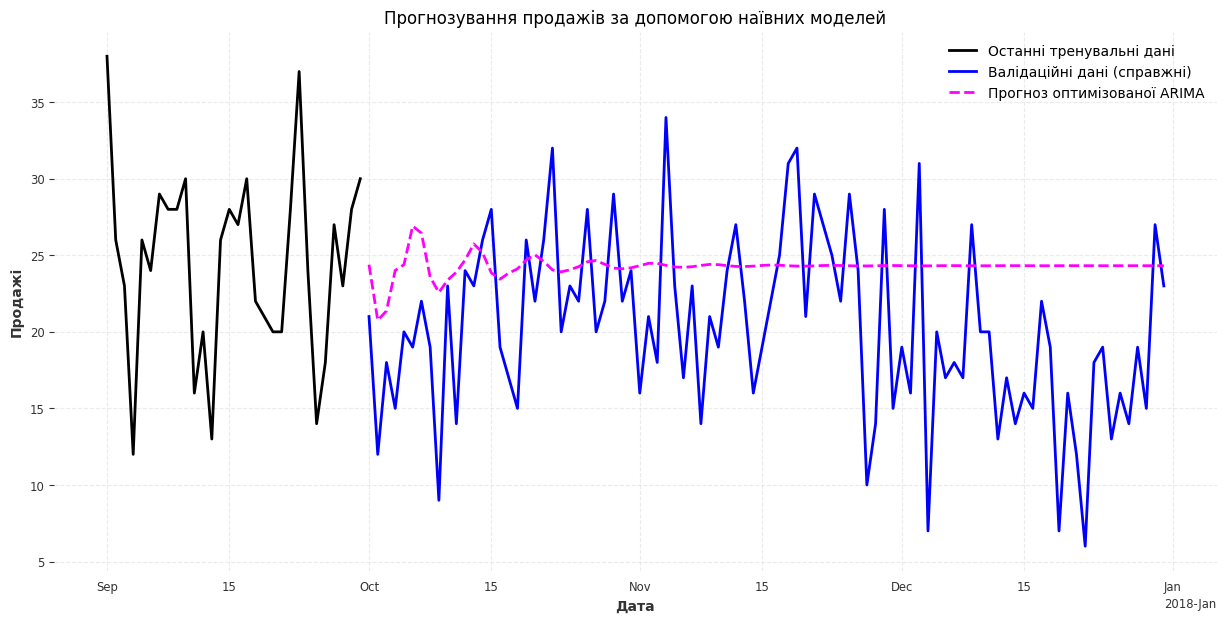

In [43]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
auto_arima_forecast.plot(label="Прогноз оптимізованої ARIMA", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Виснвовок**

Результат з AutoARIMA показує, що, на жаль, якість прогнозу не поліпшилася. Помилка MAPE для оптимізованої ARIMA становить 39.49%, що навіть трохи гірше, ніж результат нашої першої спроби (39.53%) і значно гірше, ніж у наївної моделі (38.17%).

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [44]:
from darts.models import Prophet

In [45]:
prophet_model = Prophet()
prophet_model.fit(train)
prophet_forecast = prophet_model.predict(len(val))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi911p_z4/etp3xc7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi911p_z4/gijjvsyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89664', 'data', 'file=/tmp/tmpi911p_z4/etp3xc7g.json', 'init=/tmp/tmpi911p_z4/gijjvsyj.json', 'output', 'file=/tmp/tmpi911p_z4/prophet_modelpv0xbo4s/prophet_model-20250902120118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
mape_error = mape(val, prophet_forecast)
print(f"Помилка MAPE для моделі Prophet: {mape_error:.2f}%")

Помилка MAPE для моделі Prophet: 23.80%


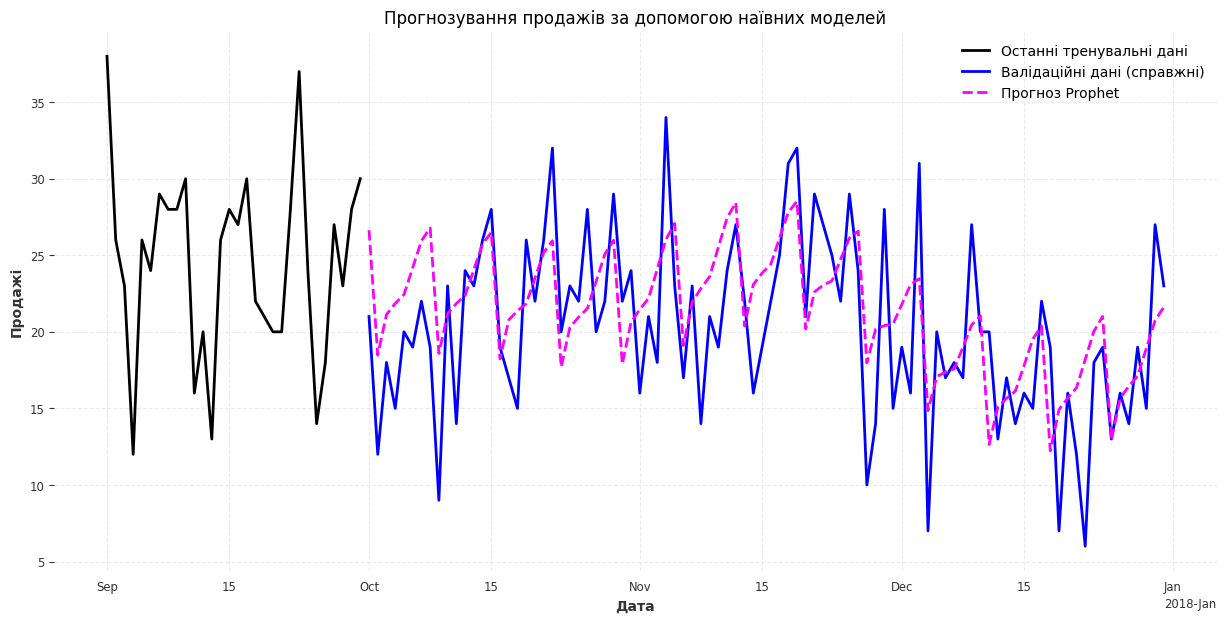

In [47]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
prophet_forecast.plot(label="Прогноз Prophet", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Виснвовк**

Prophet має MAPE 23.80%, що є найкращим результатом з усіх моделей, які на даний момент тестували. Це значно краще, ніж наївна модель (38.17%), ExponentialSmoothing (36.65%) та ARIMA (39.49%). Це навіть трохи краще, ніж у XGBoost (24.50%).

На графіку видно, що прогноз Prophet доволі непогано повторює справжні валідаційні дані.


15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [48]:
from darts.models import RNNModel

In [49]:
rnn_model = RNNModel(
    model='RNN',
    input_chunk_length=14,
    output_chunk_length=len(val),
    n_epochs=20,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42,
    log_tensorboard=True,
    force_reset=True
)

rnn_model.fit(train, verbose=True)
rnn_forecast = rnn_model.predict(len(val))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [50]:
mape_error = mape(val, rnn_forecast)
print(f"Помилка MAPE для моделі RNN: {mape_error:.2f}%")

Помилка MAPE для моделі RNN: 27.17%


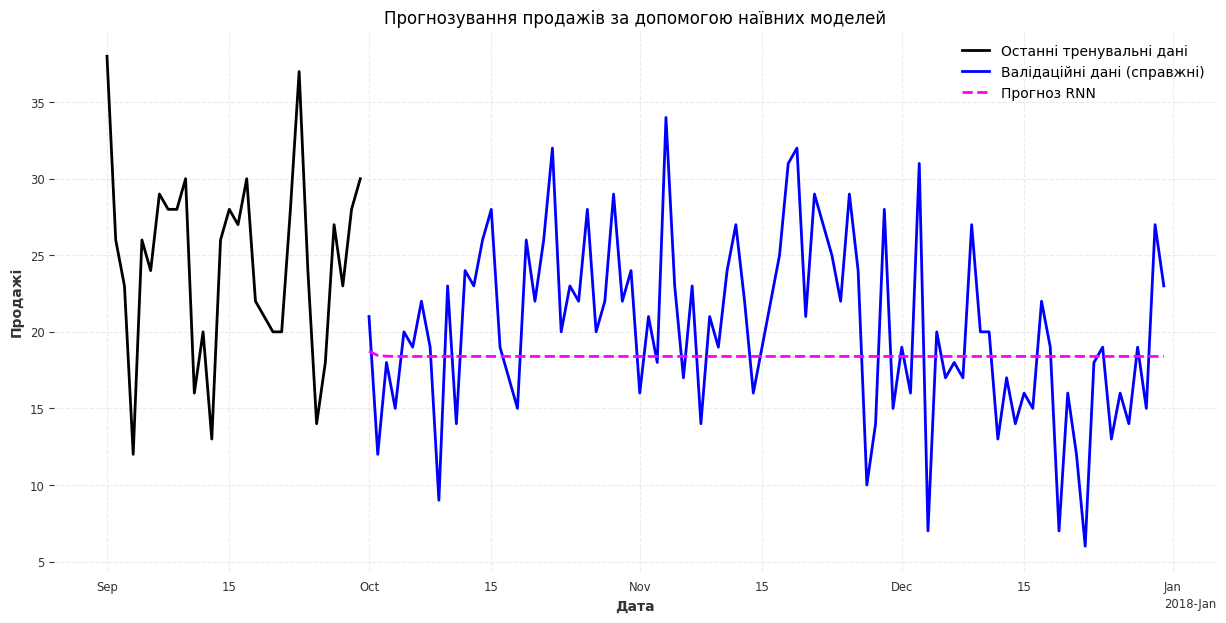

In [51]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
rnn_forecast.plot(label="Прогноз RNN", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Висновок**

MAPE 27.17% свідчить про те, що RNNModel виявилася досить точною, але не перевершила Prophet (23.80%) або XGBoost (24.50%). Вона показала кращий результат, ніж наївна модель (38.17%) та ARIMA (39.49%).

Але

На графіку прогноз RNN (фіолетова пунктирна лінія) є майже прямою лінією, яка не захоплює тижневу сезонність. Можливо параметри були неоптимальні, або 20 епох все ж таки було недостатньо.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [52]:
start_point = pd.Timestamp('2017-01-01')

In [53]:
historical_forecasts = prophet_model.historical_forecasts(
    series=series,
    start=start_point,
    forecast_horizon=30,
    stride=30,
    retrain=True,
    last_points_only=False,  # Зберігаємо всі прогнози
    verbose=True
)

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi911p_z4/tllpurev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi911p_z4/5krbddy0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51634', 'data', 'file=/tmp/tmpi911p_z4/tllpurev.json', 'init=/tmp/tmpi911p_z4/5krbddy0.json', 'output', 'file=/tmp/tmpi911p_z4/prophet_modelhxnh1li6/prophet_model-20250902120139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   8%|▊         | 1/12 [00:00<00:03,  3.34it/s]INFO:prophet:D

In [54]:
concatenated_forecasts = historical_forecasts[0]

for i in range(1, len(historical_forecasts)):
    concatenated_forecasts = concatenated_forecasts.append(historical_forecasts[i])

actual_slice = series.slice(concatenated_forecasts.start_time(), concatenated_forecasts.end_time())

In [55]:
mape_error = mape(actual_slice, concatenated_forecasts)
print(f"Помилка MAPE за весь період бектесту (Prophet, historical_forecasts): {mape_error:.2f}%")

Помилка MAPE за весь період бектесту (Prophet, historical_forecasts): 21.11%


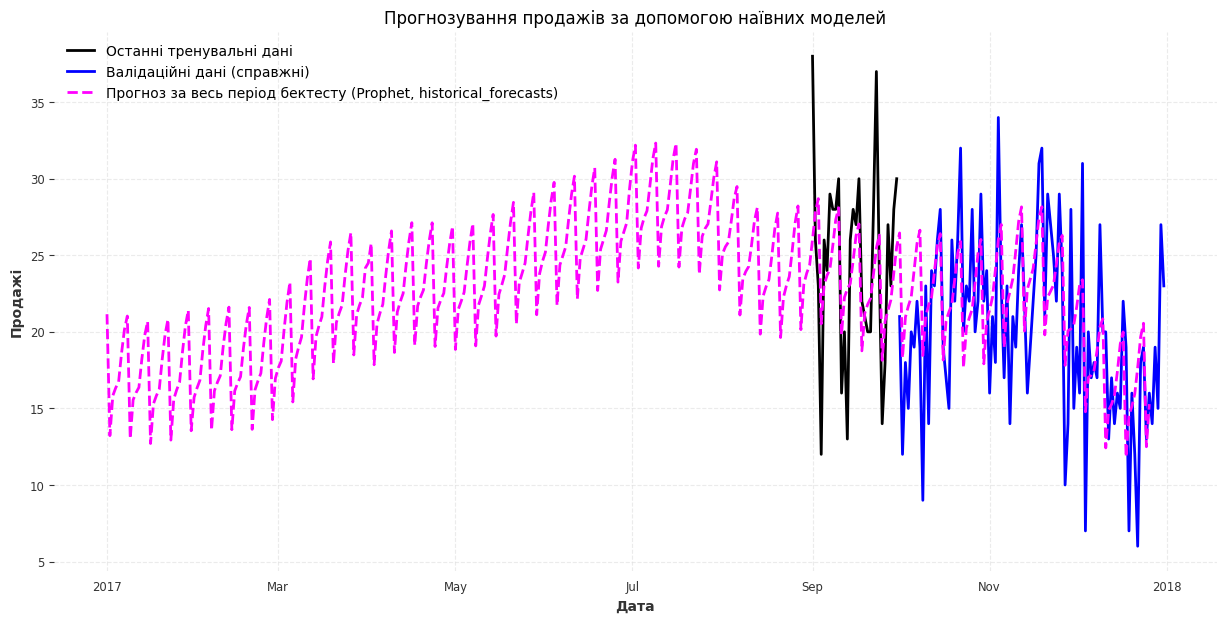

In [56]:
plt.figure(figsize=(15, 7))

train.tail(30).plot(label="Останні тренувальні дані", color='black')

val.plot(label="Валідаційні дані (справжні)", color='blue', linewidth=2)
concatenated_forecasts.plot(label="Прогноз за весь період бектесту (Prophet, historical_forecasts)", color='magenta', linestyle='--', linewidth=2)

plt.title('Прогнозування продажів за допомогою наївних моделей')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.